# Goal: fit both synch and dust in the case where $\beta = \rm const.$ (e.g. the 0x0 moment)

In [1]:
%load_ext autoreload
%load_ext line_profiler

In [2]:
import sys
sys.path.append('../../') #takes us to the directory named foreground_functions that housed the foreground_function.py 
#and the w3j.npy files

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize

Populating the interactive namespace from numpy and matplotlib


In [3]:
#the D_ells of the CMB with r=0.01
camb_lens_r1 = loadtxt('../../power_spectra/camb_lens_r1.dat').T
camb_lens_nobb = loadtxt('../../power_spectra/camb_lens_nobb.dat').T
primo_bb = camb_lens_r1[3]
lens_bb = camb_lens_nobb[3]
r = 0.01
bb = r * primo_bb + lens_bb

In [4]:
#the parameters chosen here (except gamma) are from the BICEP 2018 paper. The alphas differ by addition of 2, as we've
#calculated the C_ells, while the BICEP paper models the D_ells. The amplitudes also have had to be scaled to pivot
#frequency of 95 GHz so differ by a factor (95/original pivot)^beta
params_s = [1.23e-2, -2.6, -3.1, -2.5]
A_s, alpha_s, beta_s, gamma_s = params_s
params_d = [5.63e-1, -2.4, 1.6, -3.5] 
A_d, alpha_d, beta_d, gamma_d = params_d

params = params_s + params_d

nside=128
ells = np.arange(384)
freqs = np.linspace(30, 300, 10)*1.e9

In [18]:
%autoreload

In [6]:
fg_const = ff.auto0x0_fg(ells, freqs, params)

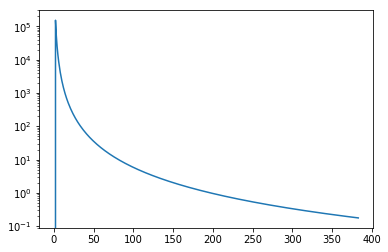

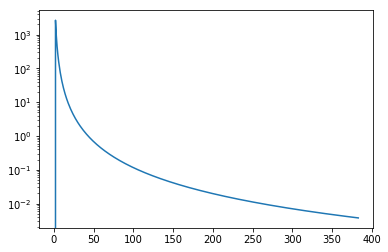

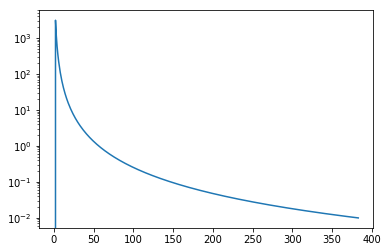

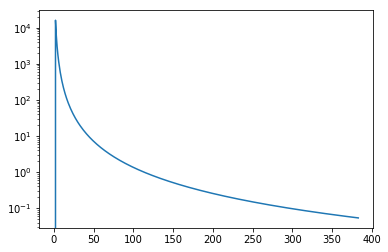

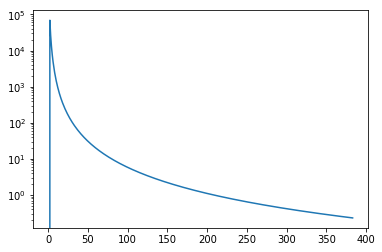

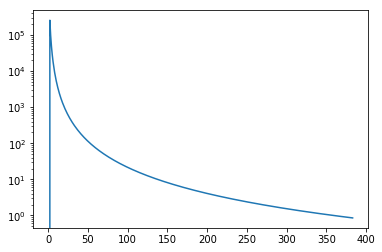

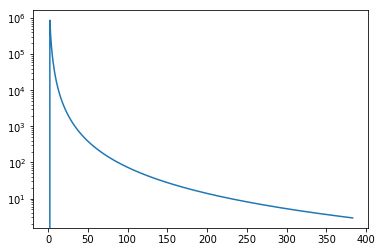

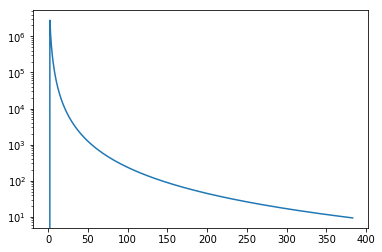

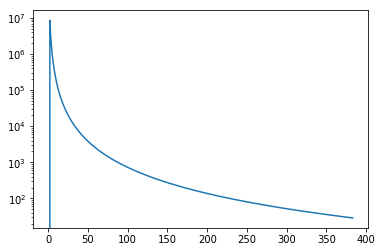

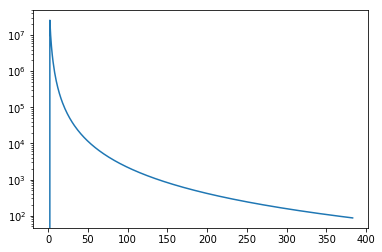

In [8]:
for i in range(len(freqs)):
    figure()
    semilogy(fg_const[i])

In [11]:
maps = ff.map_const_beta_fg(ells, freqs, [A_s, alpha_s, beta_s, A_d, alpha_d, beta_d])

In [12]:
maps.shape

(10, 196608)

In [19]:
data_synch = ff.const_ps_data_synch(ells, freqs, params_s)
data_dust = ff.const_ps_data_dust(ells, freqs, params_d)
data_fg = ff.const_ps_data_fg(ells, freqs, params)

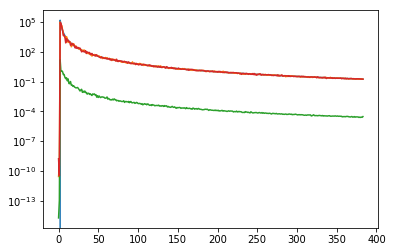

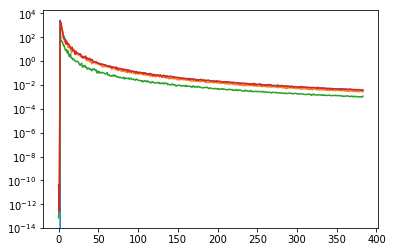

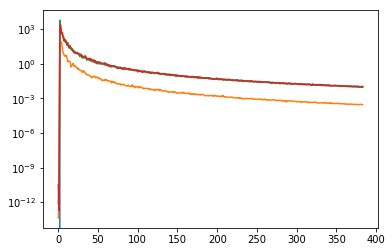

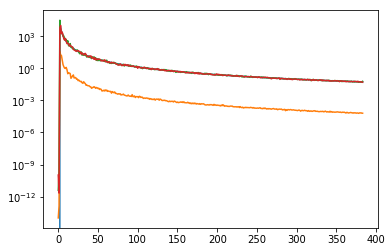

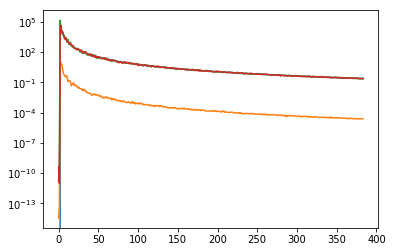

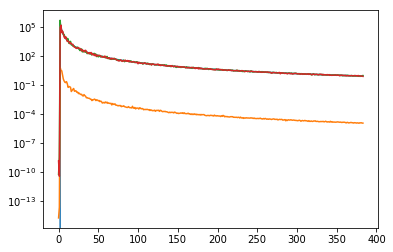

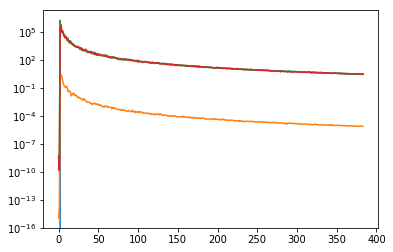

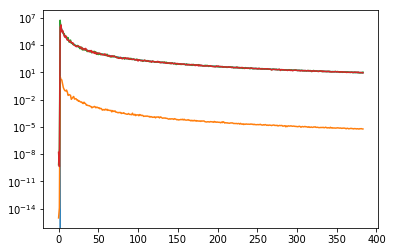

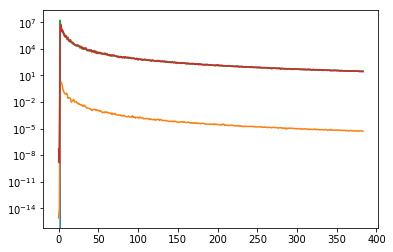

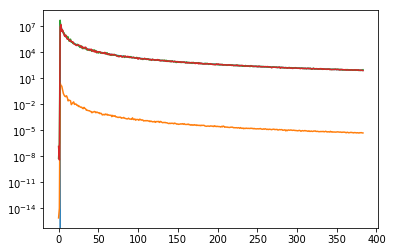

In [22]:
for i in range(len(freqs)):
    figure()
    semilogy(ells, fg_const[i])
    semilogy(ells, data_synch[i])
    semilogy(ells, data_dust[i])
    semilogy(ells, data_fg[i])

In [23]:
#define the function we're trying to fit, it will be the auto0x0_fg function, but not taking the parameter gamma
#so that the optimizer doesn't get confused.

In [29]:
def chi2(params, ells, freqs, data):
    A_s, alpha_s, beta_s, A_d, alpha_d, beta_d = params
    long_params = [A_s, alpha_s, beta_s, 0.0, A_d, alpha_d, beta_d, 0.0]

    chi2=0
    model_made = ff.auto0x0_fg(ells, freqs, long_params)

    var = np.zeros((len(freqs),len(ells)))
    for ell in range(len(ells)):
        var[:,ell] = 2/(2*ell+1)
    cosmic_var = var * data**2

    #don't count the first 30 ell in the objective function.
    chi2 = (data[:,30:] - model_made[:,30:])**2 / cosmic_var[:,30:]
    return np.sum(chi2)

In [32]:
chi2([A_s, alpha_s, beta_s, A_d, alpha_d, beta_d], ells, freqs, data_fg)

3635.863097108577

In [33]:
params_short = [A_s, alpha_s, beta_s, A_d, alpha_d, beta_d]

In [34]:
initial = [1., -1., -1., 1., -1., 1.]

In [35]:
start=time.time()
result = minimize(chi2, initial, args=(ells, freqs, data_fg), method='L-BFGS-B')
print(time.time()-start)
print(result)

0.31390905380249023
      fun: 3530.1036276610016
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.51327651, -0.06580194,  0.1155513 ,  0.05256879, -0.06602932,
        0.13146746])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 511
      nit: 62
   status: 0
  success: True
        x: array([ 0.01209025, -2.60027489, -3.10312041,  0.54837325, -2.38508382,
        1.60034609])


In [48]:
x = result.x
long_x = np.zeros(8)
long_x[:3] = x[:3]
long_x[4:7] = x[3:]
print(long_x)
fit = ff.auto0x0_fg(ells, freqs, long_x)
print((x-params_short)/params_short*100)
print(chi2(x, ells, freqs, data_fg))
print(chi2(params_short, ells, freqs, data_fg))

[ 0.01209025 -2.60027489 -3.10312041  0.          0.54837325 -2.38508382
  1.60034609  0.        ]
[-1.70527165  0.01057262  0.10065835 -2.5980019  -0.62150761  0.02163075]
3530.1036276610016
3635.863097108577


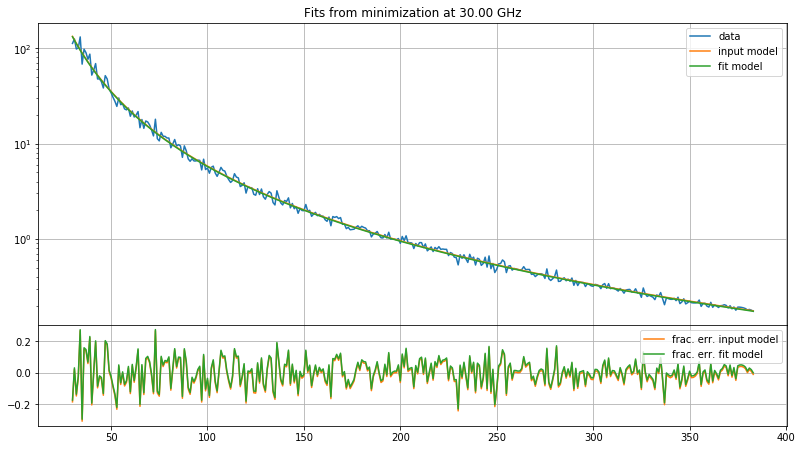

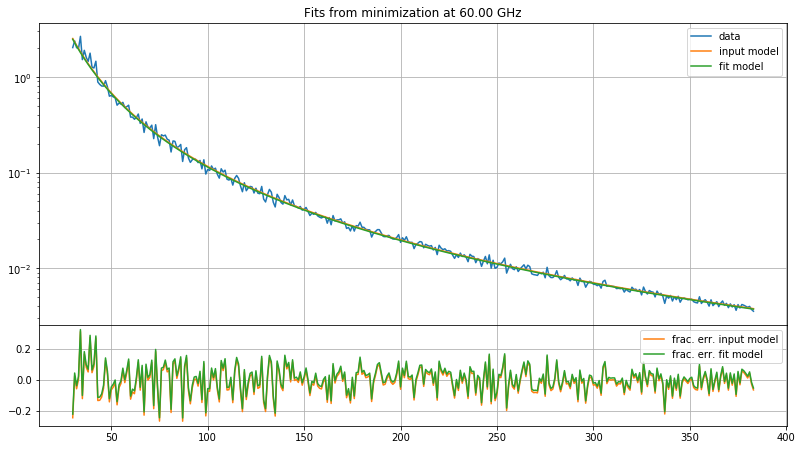

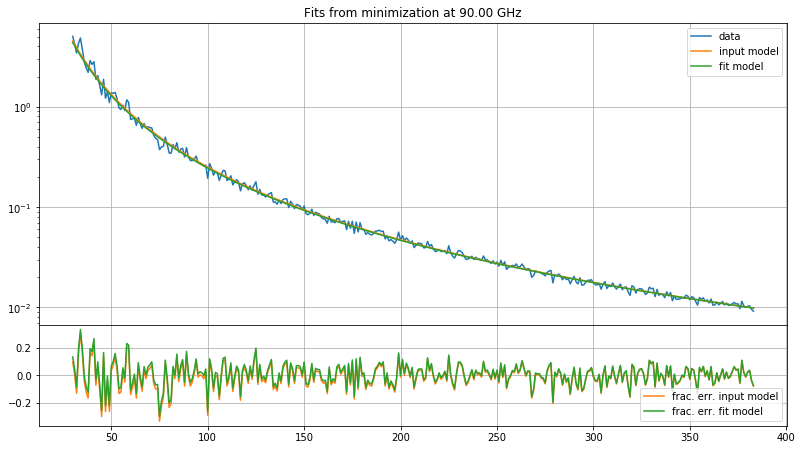

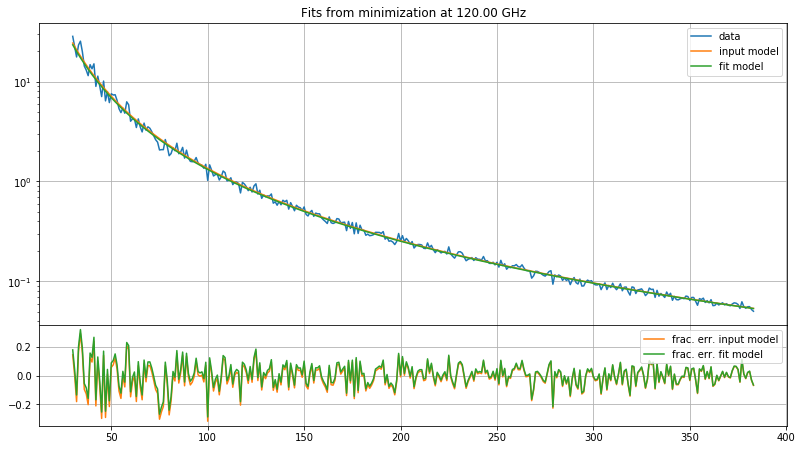

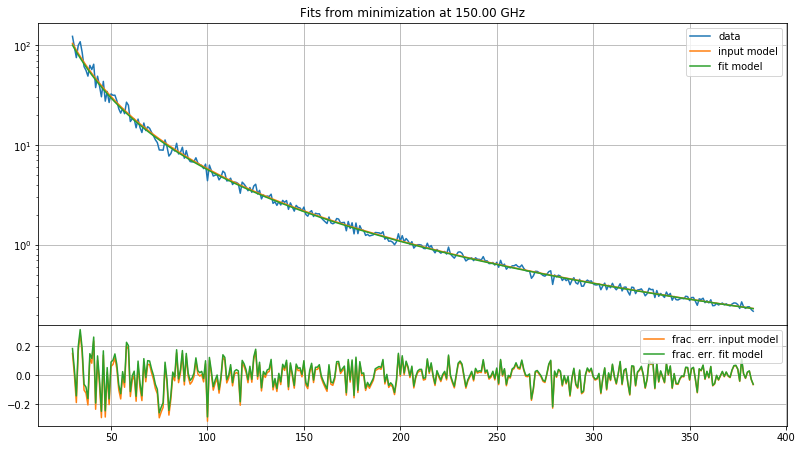

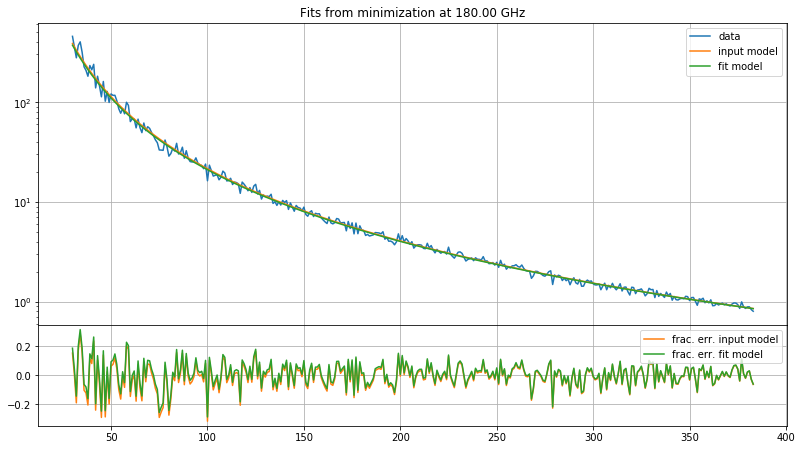

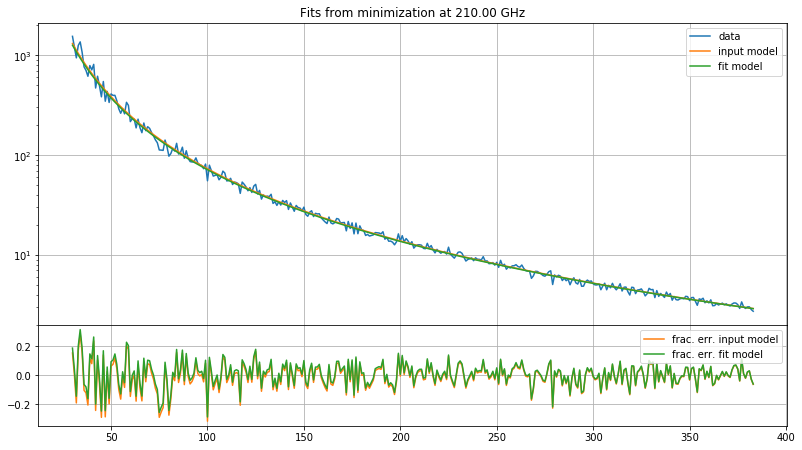

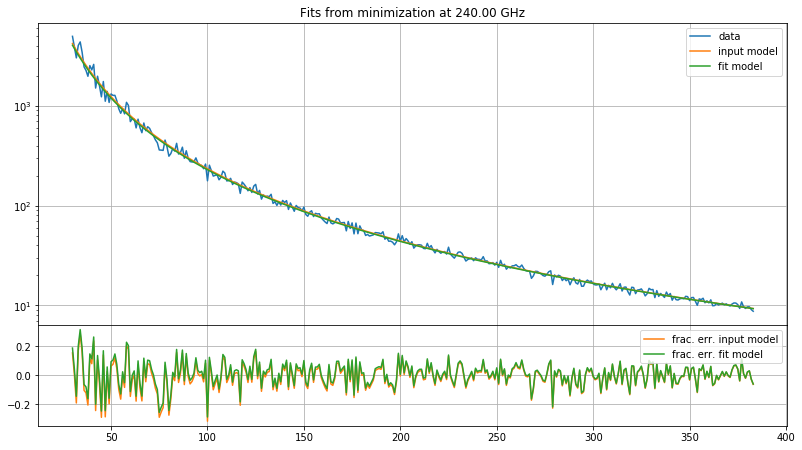

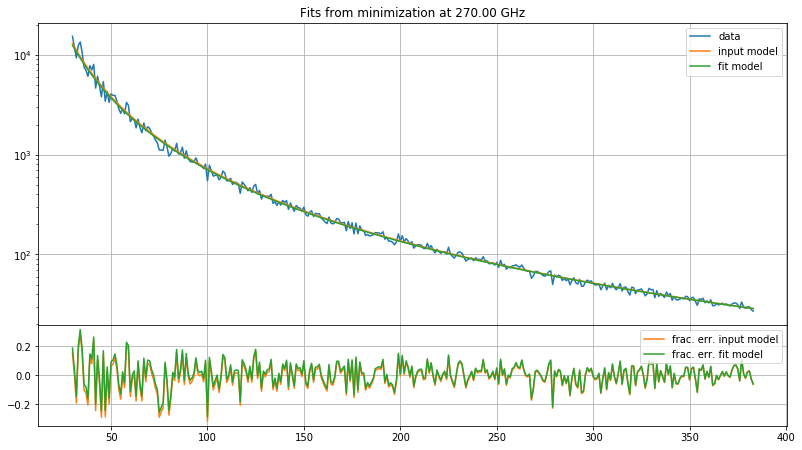

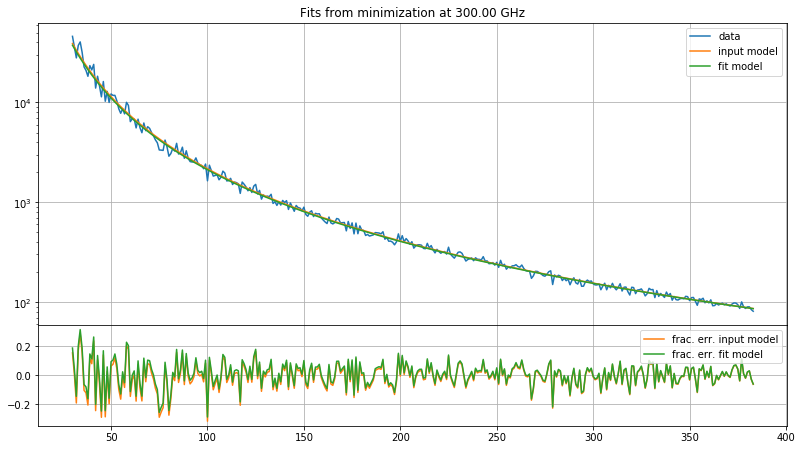

In [44]:
for i in range(len(freqs)):
    fig1 = figure(figsize=(13,7))
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    semilogy(ells[30:], data_fg[i][30:], label='data')
    semilogy(ells[30:], fg_const[i][30:], label='input model', color='C1')
    semilogy(ells[30:], fit[i][30:], label='fit model', color='C2')
    grid()
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    
    
    
    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    plot(ells[30:], (data_fg[i][30:]-fg_const[i][30:])/data_fg[i][30:], color='C1', label='frac. err. input model')
    plot(ells[30:], (data_fg[i][30:]-fit[i][30:])/data_fg[i][30:], color='C2', label='frac. err. fit model')
    legend()
    grid()

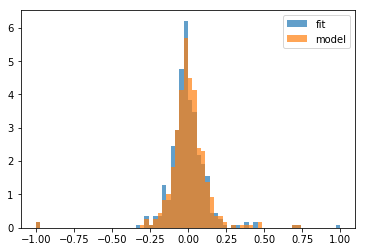

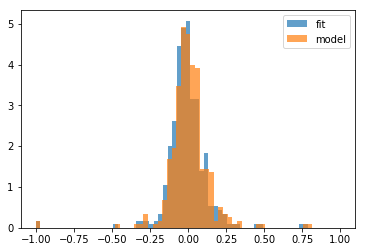

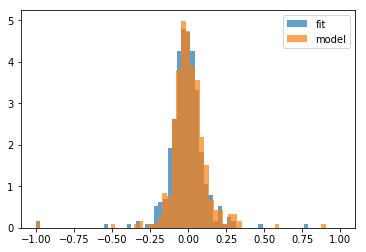

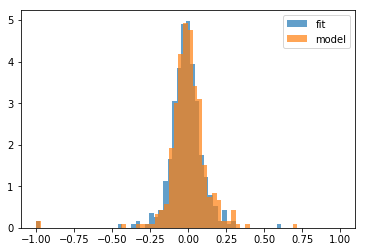

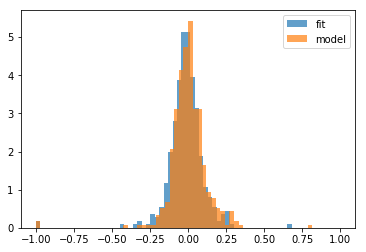

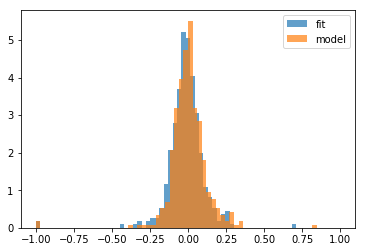

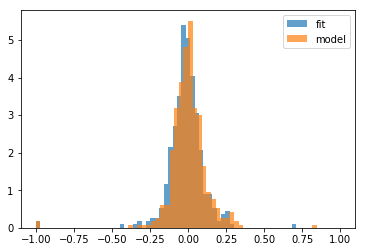

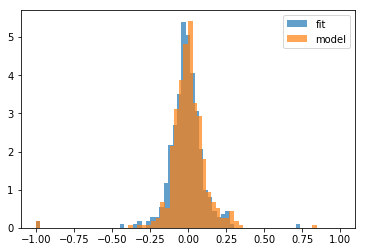

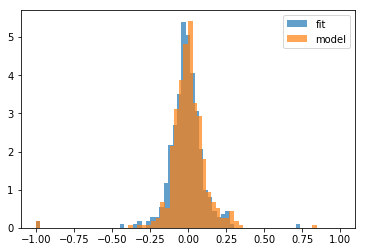

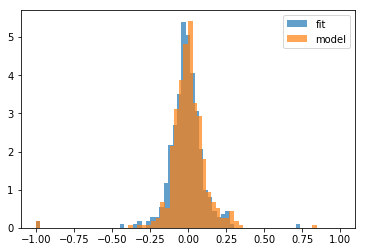

In [45]:
for i in range(len(freqs)):
    figure()
    hist((fit[i]-data_fg[i])/data_fg[i], bins='auto', density=True, alpha=0.7, label='fit', range=(-1,1))
    hist((fg_const[i]-data_fg[i])/data_fg[i], bins='auto', density=True, alpha=0.7, label='model', range=(-1,1))
    legend()